# # COVID-19 Literature Clusters

Use subversion in Linux to download just the relevant directory with the XML files from GitHub by replacing tree/master with trunk.

In [ ]:
#svn checkout https://github.com/midas-network/COVID-19/trunk/documents/mendeley_library_files/xml_files

In [1]:
from __future__ import unicode_literals
import os
import subprocess
#subprocess.check_call(['python','-m','pip','install','https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz'])
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import OrderedDict
from collections import Counter
from collections import defaultdict
from bs4 import BeautifulSoup as bs
from io import StringIO
import string
from tqdm import tqdm
from xml.etree.ElementTree import iterparse
from xml.parsers.expat import ParserCreate
import xml.etree.cElementTree as et
#Relevant Modeling Libraries
import pyLDAvis
import pyLDAvis.sklearn
import tensorflow as tf
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
import spacy
import en_core_web_sm # model for common English
import en_core_sci_lg # model for biomedical text
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from itertools import groupby 
from operator import itemgetter 

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
C:\Anaconda3\lib\site-packages\spacy\util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Anaconda3\lib\site-packages\spacy\util.py:271: UserWarning: [W031] Model 'en_core_sci_lg' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a new

In [2]:
# Read the most recent MIDAS Mendeley paper library XML file.
xfile="C:/Jobs/Docugami/Assignment1_Docugami/xml_files/mendeley_document_library_2020-03-25.xml"
# Use ElementTree to parse xml and convert levels to lists
tree=ET.parse(xfile)
root=tree.getroot()
tags=[elem.tag for elem in root.iter()]

In [3]:
# Extract tags from xml and get frequency of each tag
class OrderedCounter(Counter, OrderedDict):
     'Counter that remembers the order elements are first seen'
     def __repr__(self):
         return '%s(%r)' % (self.__class__.__name__,
                            OrderedDict(self))
     def __reduce__(self):
         return self.__class__, (OrderedDict(self),)
oc=dict(OrderedCounter(tags))
ocl=list(oc)
# xml to BeautifulSoup(bs) table
with open(xfile, "r", encoding="utf-8") as file:
    content=file.readlines()
    content="".join(content)
    bs_content=bs(content,"lxml")
mList=[]
for i in ocl:
    j=bs_content.find_all(i)
    k=[t.text for t in j]
    mList.append(k)
# Number labels
listn=[]
i=0
for j in ocl:
    k=(i,j)
    listn.append(k)
    i+=1        
#(33, 'abstract')
abt=mList[33]

In [6]:
# Tokenize words and phrases
# import stopwords variable
exec(open('covid19_stopwords.py').read())
punctuations = string.punctuation
stopwords=covid19_stopwords
# Convert text to lowercase and separate words with commas
data = [line.strip() for line in abt]
texts = [[word.lower() for word in text.split()] for text in data]
# remove xml tags
no={'<p>','<bold>background</bold>',':','</p>'}
ts=[]
for i in texts:
    j=[e for e in i if e not in no]
    ts.append(str(j))
tss=[]
for i in ts:
    j=i.replace("', '"," ")
    tss.append(j)

In [7]:
# Tokenize words and phrases
# Parser
parser = en_core_sci_lg.load()
parser.max_length = 7000000
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens
# Convert to dataframe with word counts
df=pd.DataFrame(tss)
df['abstract']=df[0]
df.drop(df.columns[0],axis=1,inplace=True)
df['abstract_word_count']=df['abstract'].apply(lambda x: len(x.strip().split()))
tqdm.pandas()
df["processed_text"] = df["abstract"].progress_apply(spacy_tokenizer)


 23%|████████████▋                                          | 197/851 [00:12<00:31, 20.79it/s]


 46%|█████████████████████████▏                             | 390/851 [00:25<00:41, 11.07it/s]


 71%|██████████████████████████████████████▊                | 600/851 [00:37<00:13, 18.17it/s]


 93%|███████████████████████████████████████████████████▎   | 793/851 [00:49<00:03, 17.61it/s]


100%|███████████████████████████████████████████████████████| 851/851 [00:53<00:00, 15.96it/s]


In [10]:
# Use tf-idf to convert str data to measure importance each word is to instance of literture as whole.
# Vectorize data: cluster based on content of abstracts. 
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X
text=df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(851, 4096)

In [11]:
# # PCA & Clustering
# Apply Principal Component Analysis (PCA) to vectorized data
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(851, 649)

In [12]:
# k-means categorizes each vector by taking mean distance to randomly initialized centroid. 
# Find best k value via distortion at different k values.
# Distortion computes the sum of squared distances from each point to its assigned center. 
# When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))   

Found distortion for 2 clusters
Found distortion for 3 clusters
Found distortion for 4 clusters
Found distortion for 5 clusters
Found distortion for 6 clusters
Found distortion for 7 clusters
Found distortion for 8 clusters
Found distortion for 9 clusters
Found distortion for 10 clusters
Found distortion for 11 clusters
Found distortion for 12 clusters
Found distortion for 13 clusters
Found distortion for 14 clusters
Found distortion for 15 clusters
Found distortion for 16 clusters
Found distortion for 17 clusters
Found distortion for 18 clusters
Found distortion for 19 clusters
Found distortion for 20 clusters
Found distortion for 21 clusters
Found distortion for 22 clusters
Found distortion for 23 clusters
Found distortion for 24 clusters
Found distortion for 25 clusters
Found distortion for 26 clusters
Found distortion for 27 clusters
Found distortion for 28 clusters
Found distortion for 29 clusters
Found distortion for 30 clusters
Found distortion for 31 clusters
Found distortion f

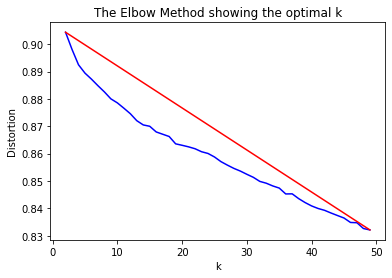

In [13]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]
# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [14]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [15]:
# # Dimensionality Reduction with t-SNE
# t-SNE reduces high dimension feature vector to 2 dimensions
# t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 851 samples in 0.653s...
[t-SNE] Computed neighbors for 851 samples in 5.780s...
[t-SNE] Computed conditional probabilities for sample 851 / 851
[t-SNE] Mean sigma: 0.400479
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.633247
[t-SNE] KL divergence after 1000 iterations: 1.372160


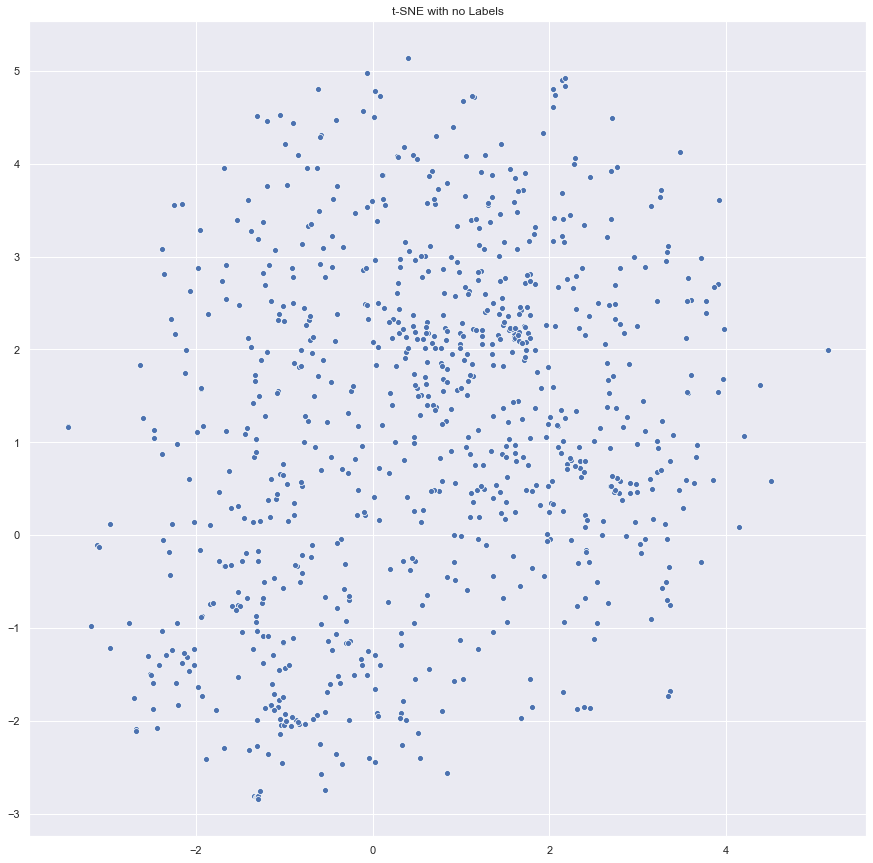

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
palette = sns.color_palette("bright", 1)
# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

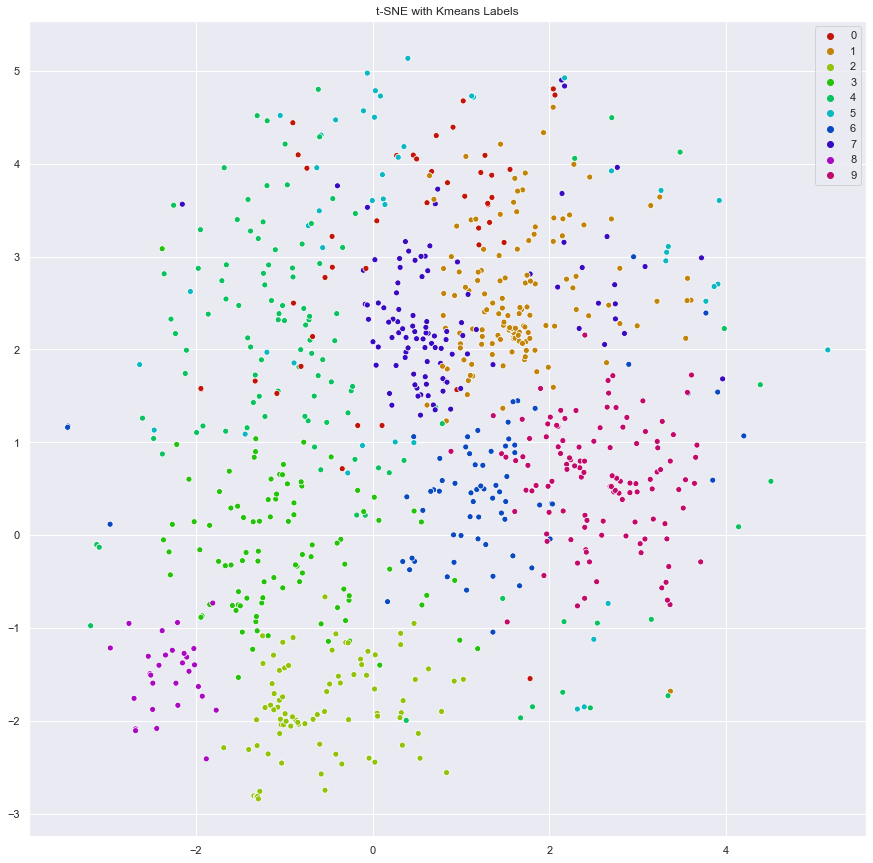

In [17]:
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib import pyplot as plt
import seaborn as sns
# sns settings
sns.set(rc={'figure.figsize':(15,15)})
# colors
#palette = sns.hls_palette(20, l=.4, s=.9)
palette = sns.hls_palette(10, l=.4, s=.9)
# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
vectorizers = []
#for ii in range(0, 20):
for ii in range(0, 10):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
df['processed_text']    

<>:7: DeprecationWarning: invalid escape sequence \-
<>:7: DeprecationWarning: invalid escape sequence \-
<>:7: DeprecationWarning: invalid escape sequence \-
<ipython-input-18-7f9e2d7db8a1>:7: DeprecationWarning: invalid escape sequence \-
  vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))


0      current novel coronavirus outbreak appear orig...
1      outbreak coronavirus disease 2019 covid-19 cau...
2      background late december 2019 new endemic spre...
3      global airline network play key role global im...
4      beginning 2020 emergence covid-19 outbreak cau...
                             ...                        
846    1 march 2020 iran report 987 covid-19 case inc...
847    1 march 2020 iran report 987 covid-19 case inc...
848    novel coronavirus disease 2019 covid-19 outbre...
849    novel coronavirus covid-19 continue grow rapid...
850    sars-cov-2 viral load upper respiratory specim...
Name: processed_text, Length: 851, dtype: object

In [19]:
vectorized_data = []
for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [20]:
# number of topics per cluster
#NUM_TOPICS_PER_CLUSTER = 20
NUM_TOPICS_PER_CLUSTER = 10
lda_models = []
#for ii in range(0, 20):
for ii in range(0, 10):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [21]:
clusters_lda_data = []
for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
clusters_lda_data

[array([[1.40848188e-03, 1.40861840e-03, 1.40876731e-03, 1.40849625e-03,
         9.87322243e-01, 1.40848707e-03, 1.40879014e-03, 1.40890725e-03,
         1.40864101e-03, 1.40856747e-03],
        [4.34791156e-04, 4.34834308e-04, 4.34858098e-04, 4.34796218e-04,
         9.96086513e-01, 4.34791332e-04, 4.34863312e-04, 4.34856959e-04,
         4.34857938e-04, 4.34837981e-04],
        [4.69499328e-04, 4.69530458e-04, 4.69587543e-04, 4.69507503e-04,
         4.69633312e-04, 4.69502824e-04, 4.69672598e-04, 4.69572673e-04,
         9.95773859e-01, 4.69634316e-04],
        [1.04168725e-03, 1.04178435e-03, 9.90623670e-01, 1.04170097e-03,
         1.04198197e-03, 1.04169004e-03, 1.04189832e-03, 1.04186896e-03,
         1.04188219e-03, 1.04183586e-03],
        [1.25003356e-03, 1.25035180e-03, 6.21043369e-01, 1.25005913e-03,
         3.68954912e-01, 1.25003660e-03, 1.25039533e-03, 1.25042492e-03,
         1.25029014e-03, 1.25012736e-03],
        [4.80785629e-04, 4.80826625e-04, 4.80870182e-04, 4.8

In [29]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])               
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [30]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [27]:
# Sort processed_test and keywords to match order of y_pred
# lab=list(df['processed_text'])
# yp=list(y_pred)
# ys=sorted(y_pred)
# dft=pd.DataFrame(list(zip(ys,lab,yp)),columns=['ys','abstract','yp'])
# mask = dft.applymap(lambda x: x is None)
# cols = dft.columns[(mask).any()]
# for col in dft[cols]:
#     dft.loc[mask[col], col] = ''
# dft['abstract']=dft['abstract'].str.replace('abstract','')
# dft['abstract']=dft['abstract'].str.replace('background','')
# dtf=dft

# # Sorter1
# dtf=dtf.sort_values(by='yp')

# dfk=dtf
# dfk=pd.DataFrame(list(zip(dtf['ys'],dtf['abstract'])),columns=['ys','abstract'])

# kc=all_keywords
# k2=[i for j in kc for i in j]
# gs=[]
# ali=list(dfk['abstract'])
# ix=list(dfk['ys'])
# dic1=dict(zip(ix,ali))
# for i,j in dic1.items():
#     for k in k2:
#         if k in ali:
#             gs.append([i,j,k])
            
# ali0=[i for i in k2 if i in ali[0]]
# ali1=[i for i in k2 if i in ali[1]]
# ali2=[i for i in k2 if i in ali[2]]
# ali3=[i for i in k2 if i in ali[3]]
# ali4=[i for i in k2 if i in ali[4]]
# ali5=[i for i in k2 if i in ali[5]]
# ali6=[i for i in k2 if i in ali[6]]
# ali7=[i for i in k2 if i in ali[7]]
# ali8=[i for i in k2 if i in ali[8]]
# ali9=[i for i in k2 if i in ali[9]]

# alis=list(zip([ali0,ali1,ali2,ali3,ali4,ali5,ali6,ali7,ali8,ali9]))
# alis=str(alis)

In [31]:
f=open('topics.txt','w')
count = 0
for ii in all_keywords:
    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1
f.close()

In [32]:
import pickle
# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))
# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))
# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

Classify
Use supervised learning to see how well the clustering generalizes

In [33]:
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [34]:
from sklearn.model_selection import train_test_split
# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)
print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 680
X_test size: 171 



In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)
# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  78.235 %
     Precision:  81.330 %
        Recall:  73.531 %
      F1 score:  75.424 %


**Precision** is ratio of True Positives to True Positives + False Positives. **Recall** (also known as TPR) measures the ratio of True Positives to True Positives + False Negatives. It measures the ratio of positive instances that are correctly detected by the classifer.
**F1 score** is the harmonic average of the precision and recall. F1 score will only be high if both precision and recall are high

In [36]:
# test for overfitting
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)
# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  66.667 %
     Precision:  60.768 %
        Recall:  59.077 %
      F1 score:  58.445 %


C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# See how model generalizes across whole dataset
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 83.313 %


In [38]:
from bokeh.models import CustomJS
# handle the currently selected article
def selected_code():
    code = """
            var titles = [];
            var authors = [];
            var journals = [];
            var links = [];
            cb_data.source.selected.indices.forEach(index => titles.push(source.data['titles'][index]));
            cb_data.source.selected.indices.forEach(index => authors.push(source.data['authors'][index]));
            cb_data.source.selected.indices.forEach(index => journals.push(source.data['journal'][index]));
            cb_data.source.selected.indices.forEach(index => links.push(source.data['links'][index]));
            title = "<h4>" + titles[0].toString().replace(/<br>/g, ' ') + "</h4>";
            authors = "<p1><b>Authors:</b> " + authors[0].toString().replace(/<br>/g, ' ') + "<br>"
            // journal = "<b>Journal</b>" + journals[0].toString() + "<br>"
            link = "<b>Link:</b> <a href='" + "http://doi.org/" + links[0].toString() + "'>" + "http://doi.org/" + links[0].toString() + "</a></p1>"
            current_selection.text = title + authors + link
            current_selection.change.emit();
    """
    return code

# handle the keywords and search
def input_callback(plot, source, out_text, topics): 

    # slider call back for cluster selection
    callback = CustomJS(args=dict(p=plot, source=source, out_text=out_text, topics=topics), code="""
				var key = text.value;
				key = key.toLowerCase();
				var cluster = slider.value;
                var data = source.data; 
                x = data['x'];
                y = data['y'];
                x_backup = data['x_backup'];
                y_backup = data['y_backup'];
                labels = data['desc'];
                abstract = data['abstract'];
                titles = data['titles'];
                authors = data['authors'];
                journal = data['journal'];
                if (cluster == '20') {
                    out_text.text = 'Keywords: Slide to specific cluster to see the keywords.';
                    for (i = 0; i < x.length; i++) {
						if(abstract[i].includes(key) || 
						titles[i].includes(key) || 
						authors[i].includes(key) || 
						journal[i].includes(key)) {
							x[i] = x_backup[i];
							y[i] = y_backup[i];
						} else {
							x[i] = undefined;
							y[i] = undefined;
						}
                    }
                }
                else {
                    out_text.text = 'Keywords: ' + topics[Number(cluster)];
                    for (i = 0; i < x.length; i++) {
                        if(labels[i] == cluster) {
							if(abstract[i].includes(key) || 
							titles[i].includes(key) || 
							authors[i].includes(key) || 
							journal[i].includes(key)) {
								x[i] = x_backup[i];
								y[i] = y_backup[i];
							} else {
								x[i] = undefined;
								y[i] = undefined;
							}
                        } else {
                            x[i] = undefined;
                            y[i] = undefined;
                        }
                    }
                }
            source.change.emit();
            """)
    return callback

In [68]:
# Plot data
# required libraries for plot
#subprocess.check_call(['python','-m','pip','install','call_backs'])
#from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
# github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html

In [69]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

In [70]:
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    abstracts= df['abstract'],
    labels = ["C-" + str(x) for x in y_labels],
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Abstract", "@abstracts{safe}"),
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

Loading BokehJS ...

In [71]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
#div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider

In [77]:
# STYLE
slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
#r.sizing_mode = "stretch_width"
r.sizing_mode = "stretch_both"

In [79]:
# LAYOUT OF THE PAGE
l = layout([
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('t-sne_covid-19_interactive.html')
show(l)